# Sequence-to-sequence activity recognition

In [ ]:
!pip3 install wandb

In [ ]:
!pip3 install git+https://github.com/tensorflow/addons.git

In [ ]:
from tensorflow.keras.layers import Add, Dense, Dropout, MultiHeadAttention, LayerNormalization, Layer, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tensorflow_addons.optimizers import AdamW
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split 

import math
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


## Init logger

In [ ]:
wandb.login()

sweep_config = {
  'method': 'grid',
  'metric': {
    'goal': 'maximize',
    'name': 'val_accuracy'
  },
  'parameters': {
      'epochs': {
        'value': 50
      },
      'num_layers': {
        'value': 3
      },
      'embed_layer_size': {
        'value': 128
      },
      'fc_layer_size': {
        'value': 256
      },
      'num_heads': {
        'value': 6
      },
      'dropout': {
        'value': 0.1
      },
      'attention_dropout': {
        'value': 0.1
      },
      'optimizer': {
        'value': 'adam'
      },
      'amsgrad': {
        'value': False
      },
      'label_smoothing': {
        'value': 0.1
      },
      'learning_rate': {
        'value': 1e-3
      },
      #'weight_decay': {
      #    'values': [2.5e-4, 1e-4, 5e-5, 1e-5]
      #},
      'warmup_steps': {
        'value': 10
      },
      'batch_size': {
        'value': 64
      },
      'global_clipnorm': {
        'value': 3.0
      },
    }
}

sweep_id = wandb.sweep(sweep_config, project="HAR-Transformer")


## Layer

In [ ]:
class PositionalEmbedding(Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.units = units

        self.projection = Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))

        self.dropout = Dropout(rate=dropout_rate)

    def build(self, input_shape):
        super(PositionalEmbedding, self).build(input_shape)

        self.position = self.add_weight(
            name="position",
            shape=(1, input_shape[1], self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, inputs, training):
        x = self.projection(inputs)
        x = x + self.position

        return self.dropout(x, training=training)


In [ ]:
class Encoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Encoder, self).__init__(**kwargs)

        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )

        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()

    def call(self, inputs, training):
        # Attention block
        x = self.norm_0(inputs)
        x = self.mha(
            query=x,
            value=x,
            key=x,
            training=training,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # MLP block
        y = self.norm_1(x)
        y = self.dense_0(y)
        y = self.dense_1(y)
        y = self.dropout_1(y, training=training)

        return self.add_1([x, y])


## Model

In [ ]:
class Transformer(Model):
    def __init__(
        self,
        num_layers,
        embed_dim,
        mlp_dim,
        num_heads,
        num_classes,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Transformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm = Normalization()

        # Input
        self.pos_embs = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder
        self.e_layers = [
            Encoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_layers)
        ]

        # Output
        self.norm = LayerNormalization(epsilon=1e-5)
        self.final_layer = Dense(num_classes, kernel_initializer="zeros")

    def call(self, inputs, training):
        x = self.input_norm(inputs)
        x = self.pos_embs(x, training=training)

        for layer in self.e_layers:
            x = layer(x, training=training)

        x = self.norm(x)
        x = self.final_layer(x)

        return x


## Loss

In [ ]:
def smoothed_sparse_categorical_crossentropy(label_smoothing: float = 0.0):
    def loss_fn(y_true, y_pred):
        num_classes = tf.shape(y_pred)[-1]
        y_true = tf.one_hot(y_true, num_classes)

        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True, label_smoothing=label_smoothing)
        return tf.reduce_mean(loss)

    return loss_fn

## LR scheduler

In [ ]:
def cosine_schedule(base_lr, total_steps, warmup_steps):
    def step_fn(epoch):
        lr = base_lr
        epoch += 1

        progress = (epoch - warmup_steps) / float(total_steps - warmup_steps)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        
        lr = lr * 0.5 * (1.0 + tf.cos(math.pi * progress))

        if warmup_steps:
            lr = lr * tf.minimum(1.0, epoch / warmup_steps)

        return lr

    return step_fn



In [ ]:
class PrintLR(Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({"lr": self.model.optimizer.lr.numpy()}, commit=False)

## Dataset

In [ ]:
CLASS_LABELS = np.array(
    [
        "Stand",
        "Sit",
        "Talk-sit",
        "Talk-stand",
        "Stand-sit",
        "Lay",
        "Lay-stand",
        "Pick",
        "Jump",
        "Push-up",
        "Sit-up",
        "Walk",
        "Walk-backward",
        "Walk-circle",
        "Run",
        "Stair-up",
        "Stair-down",
        "Table-tennis"
    ]
)

# load dataset
f = np.load('./new_dataset.npz')
signals = f['signals']
labels = f['labels']

# split to train-test
X_train, X_test, y_train, y_test = train_test_split(
    signals, labels, test_size=0.15, random_state=9, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=9, stratify=y_train
)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)


(60060, 300, 6) (60060, 300)
(12470, 300, 6) (12470, 300)
(10599, 300, 6) (10599, 300)


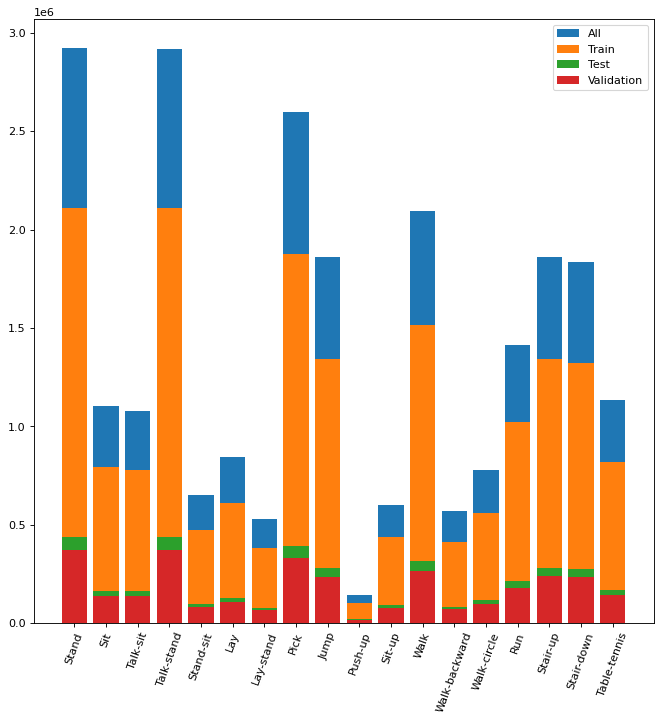

In [ ]:
plt.figure(figsize=(10, 10), dpi=80)

unique, counts = np.unique(labels, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

unique, counts = np.unique(y_test, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

unique, counts = np.unique(y_val, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

plt.legend(["All", "Train", "Test", "Validation"])

plt.show()

In [ ]:
def train(config=None):
  with wandb.init(config=config):
    config = wandb.config
    
    # Generate new model
    model = Transformer(
      num_layers=config.num_layers,
      embed_dim=config.embed_layer_size,
      mlp_dim=config.fc_layer_size,
      num_heads=config.num_heads,
      num_classes=18,
      dropout_rate=config.dropout,
      attention_dropout_rate=config.attention_dropout,
    )

    # adapt on training dataset - must be before model.compile !!!
    model.input_norm.adapt(X_train, batch_size=config.batch_size)
    print(model.input_norm.variables)

    # Select optimizer
    if config.optimizer == "adam":
      optim = Adam(
          global_clipnorm=config.global_clipnorm,
          amsgrad=config.amsgrad,
      )
    elif config.optimizer == "adamw":
      optim = AdamW(
          weight_decay=config.weight_decay,
          amsgrad=config.amsgrad,
          global_clipnorm=config.global_clipnorm,
          exclude_from_weight_decay=["position"]
      )
    else:
      raise ValueError("The used optimizer is not in list of available")

    model.compile(
      loss=smoothed_sparse_categorical_crossentropy(label_smoothing=config.label_smoothing),
      optimizer=optim,
      metrics=["accuracy"],
    )

    # Train model
    model.fit(
      X_train,
      y_train,
      batch_size=config.batch_size,
      epochs=config.epochs,
      validation_data=(X_val, y_val),
      callbacks=[
        LearningRateScheduler(cosine_schedule(base_lr=config.learning_rate, total_steps=config.epochs, warmup_steps=config.warmup_steps)),
        PrintLR(),
        WandbCallback(monitor="val_accuracy", mode='max', save_weights_only=True),
        EarlyStopping(monitor="val_accuracy", mode='max', min_delta=0.001, patience=5),
      ],
      verbose=1
    )

    model.summary()

In [ ]:
wandb.agent(sweep_id, train, count=32)

wandb: Agent Starting Run: lwikvs2y with config:
wandb: 	amsgrad: False
wandb: 	attention_dropout: 0.1
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	embed_layer_size: 128
wandb: 	epochs: 50
wandb: 	fc_layer_size: 256
wandb: 	global_clipnorm: 3
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.001
wandb: 	num_heads: 6
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	warmup_steps: 10


[<tf.Variable 'mean:0' shape=(6,) dtype=float32, numpy=
array([ 0.10979815, -0.07648689, -0.08781412,  0.03063406,  0.00979011,
        0.00650088], dtype=float32)>, <tf.Variable 'variance:0' shape=(6,) dtype=float32, numpy=
array([28.058855 ,  9.622038 , 16.08444  ,  3.0307784,  1.9513103,
        2.0505407], dtype=float32)>, <tf.Variable 'count:0' shape=() dtype=int64, numpy=18018000>]
Epoch 1/50
939/939 [==============================] - 226s 234ms/step - loss: 1.8975 - accuracy: 0.4512 - val_loss: 1.4693 - val_accuracy: 0.6309 - lr: 1.0000e-04
Epoch 2/50
939/939 [==============================] - 224s 239ms/step - loss: 1.2502 - accuracy: 0.7161 - val_loss: 1.0970 - val_accuracy: 0.7766 - lr: 2.0000e-04
Epoch 3/50
939/939 [==============================] - 224s 238ms/step - loss: 1.0634 - accuracy: 0.7823 - val_loss: 1.0177 - val_accuracy: 0.8070 - lr: 3.0000e-04
Epoch 4/50
939/939 [==============================] - 225s 240ms/step - loss: 0.9973 - accuracy: 0.8063 - val_loss: 0.94

accuracy,▁▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
lr,▁▂▃▄▄▅▆▇██████▇▇▇▇▇▇▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.99912
best_epoch,45
best_val_accuracy,0.99177
epoch,45
loss,0.58374


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
